# Applying ELI5 with NLP 

# 1)- Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings("ignore", category=DeprecationWarning)


import os
import pickle
import json
from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

# 2)- Loading data

In [2]:
df = pd.read_csv('amazon_reviews_sample100k_grocery.csv')

In [3]:
df.shape

(99982, 10)

In [5]:
df.columns

Index(['productId', 'Title', 'userId', 'Helpfulness', 'Score', 'Time', 'Text',
       'Cat1', 'Cat2', 'Cat3'],
      dtype='object')

In [4]:
df.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B0000DF3IX,Paprika Hungarian Sweet,A244MHL2UN2EYL,0/0,5.0,1127088000,While in Hungary we were given a recipe for Hu...,grocery gourmet food,herbs,spices seasonings
1,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3FL7SXVYMC5NR,3/3,5.0,1138147200,"Without a doubt, I would recommend this wholes...",grocery gourmet food,breakfast foods,cereals
2,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A12IDQSS4OW33B,3/3,5.0,1118016000,This cereal is so sweet....yet so good for you...,grocery gourmet food,breakfast foods,cereals
3,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A2GZKHC1M4PKF4,2/2,3.0,1206489600,Man I love Oh's cereal. It is really great to ...,grocery gourmet food,breakfast foods,cereals
4,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),AUGT2DOGKLHIN,2/2,5.0,1177545600,And I've tried alot of cereals. This is by far...,grocery gourmet food,breakfast foods,cereals


# 3)- Exploring data

From these 10 columns we'll use only 3 now:

- Text - review on the product
- Cat2 - label of category 2 for this product
- Cat3 - label of category 3 for this product
There's a taxonomy (hierarchical catalog) of all products with 3 categories (a.k.a. levels). Based on the review, we're going to classify it into one of level 2 categories (i.e. predicting Cat2) and level 3 categories (i.e. predicting Cat3).

In [6]:
df['Cat1'].unique()

array([' grocery  gourmet food'], dtype=object)

In [7]:
df['Cat2'].unique()

array(['herbs', 'breakfast foods', 'candy chocolate', 'dairy  eggs',
       'pantry staples', 'beverages', 'meat  poultry', 'baby food',
       'snack food', 'meat  seafood', 'sauces  dips', 'breads  bakery',
       'cooking  baking supplies', 'gourmet gifts',
       'fresh flowers  live indoor plants', 'produce'], dtype=object)

In [10]:
df['Cat3'].unique()

array(['spices  seasonings', 'cereals', 'fudge', 'butter', 'herbs',
       'caramels', 'energy drinks', 'tea', 'sauces', 'foie gras',
       'cheese', 'nut clusters', 'cooking  baking supplies',
       'crackers  biscuits', 'chocolate bars', 'vegetables', 'popcorn',
       'trail mix', 'dried beans', 'oils', 'hard candies',
       'packaged meals  side dishes', 'unknown',
       'ice cream  frozen desserts', 'crackers', 'cookies', 'coffee',
       'juices', 'pudding', 'suckers  lollipops', 'cereal', 'jams',
       'fruit', 'syrups', 'breakfast  cereal bars',
       'powdered drink mixes', 'seafood', 'baby formula',
       'canned  jarred food', 'flours  meals', 'nuts  seeds',
       'condiments', 'puffed snacks', 'baking mixes', 'cakes',
       'jelly beans', 'chips  crisps', 'chocolate covered nuts',
       'pretzels', 'chips', 'sauces gifts', 'gummy candies', 'gum',
       'fruits', 'jerky  dried meats', 'dessert toppings', 'coffee gifts',
       'live indoor plants', 'jerky', 'candy

In [8]:
df['Cat1'].value_counts()

 grocery  gourmet food    99982
Name: Cat1, dtype: int64

In [9]:
df['Cat2'].value_counts()

pantry staples                       27291
beverages                            23440
snack food                           12724
candy chocolate                      11433
breakfast foods                       6248
breads  bakery                        4240
cooking  baking supplies              2444
herbs                                 2069
gourmet gifts                         1939
fresh flowers  live indoor plants     1811
baby food                             1270
meat  poultry                         1268
meat  seafood                         1250
produce                               1196
sauces  dips                           845
dairy  eggs                            514
Name: Cat2, dtype: int64

In [11]:
df['Cat1'].nunique()

1

In [12]:
df['Cat2'].nunique()

16

In [13]:
df['Cat3'].nunique()

157

We're not intrested anymore in Cat1 because here we chose only grocery. So we have 16 Cat2 categories and 157 Cat3 categories.

# 4)- Pre-processing text data

### 4.1)- Split Dataset into X and y

In [14]:
texts, y = df['Text'], df['Cat2']

In [15]:
texts[:5]

0    While in Hungary we were given a recipe for Hu...
1    Without a doubt, I would recommend this wholes...
2    This cereal is so sweet....yet so good for you...
3    Man I love Oh's cereal. It is really great to ...
4    And I've tried alot of cereals. This is by far...
Name: Text, dtype: object

In [16]:
y[:5]

0              herbs
1    breakfast foods
2    breakfast foods
3    breakfast foods
4    breakfast foods
Name: Cat2, dtype: object

### 4.2) cleaning text

In [19]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
corpus = [] # defining corpus
for i in range(0, len(texts)): # giving range of values from 0 to 1000
    txt = re.sub('[^a-zA-Z]', ' ', texts[i]) # using i for all values instead of 1 column
    txt = txt.lower()
    txt = txt.split()
    lemm = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    txt = [lemm.lemmatize(word) for word in txt if not word in stopword_set]
    txt = ' '.join(txt)
    corpus.append(txt) # finally attach all these cleaned values to corpus directory

In [20]:
type(corpus)

list

In [21]:
# convert to series to check words
txt_corpus_clean = pd.Series(corpus)

In [22]:
txt_corpus_clean.head()

0    hungary given recipe hungarian goulash need sw...
1    without doubt would recommend wholesome sweet ...
2    cereal sweet yet good one taste addiction trie...
3    man love oh cereal really great last bite size...
4    tried alot cereal far best like cereal used ea...
dtype: object

### 4.3)- Vectorize

- bag of words
- Bigrams
- tfidf

In [23]:
vocabulary = list(enumerate(set([word for sentence in txt_corpus_clean 
                                 for word in sentence.split()])))

print('Vocabulary:', vocabulary)

Vocabulary: [(0, 'walled'), (1, 'accuracy'), (2, 'torula'), (3, 'quote'), (4, 'compromised'), (5, 'definitively'), (6, 'himalayian'), (7, 'hexane'), (8, 'caaaaake'), (9, 'triedso'), (10, 'condition'), (11, 'ballsy'), (12, 'recommends'), (13, 'pre'), (14, 'saromatic'), (15, 'heavyweight'), (16, 'addactive'), (17, 'piquant'), (18, 'grappling'), (19, 'cleft'), (20, 'orangy'), (21, 'preppy'), (22, 'amerasian'), (23, 'caesin'), (24, 'cankersores'), (25, 'ghostbusters'), (26, 'origin'), (27, 'bitterly'), (28, 'prone'), (29, 'fatiguing'), (30, 'lasksa'), (31, 'pointer'), (32, 'steer'), (33, 'shangri'), (34, 'toothache'), (35, 'patented'), (36, 'dayds'), (37, 'kardashian'), (38, 'protocal'), (39, 'omega'), (40, 'weightless'), (41, 'star'), (42, 'siu'), (43, 'entirely'), (44, 'stimorol'), (45, 'banned'), (46, 'independent'), (47, 'verypleased'), (48, 'raspberry'), (49, 'bending'), (50, 'pamphlet'), (51, 'corazonas'), (52, 'shiped'), (53, 'tactile'), (54, 'ajar'), (55, 'brim'), (56, 'purebar'), 

In [25]:
def vectorize(text): 
    vector = np.zeros(len(vocabulary)) 
    for i, word in vocabulary:
        num = 0 
        for w in text: 
            if w == word: 
                num += 1 
        if num: 
            vector[i] = num 
    return vector

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
print('Feature matrix:\n {}'.format(vect.fit_transform(txt_corpus_clean).toarray()))
print('Vocabulary')
pprint(vect.vocabulary_)

Feature matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Vocabulary
{'aa': 0,
 'aaa': 1,
 'aaaa': 2,
 'aaaaa': 3,
 'aaaaaa': 4,
 'aaaaaaaaaaaaaa': 5,
 'aaaaaaaaagghh': 6,
 'aaaaaah': 7,
 'aaaaaahhh': 8,
 'aaaaaahhhh': 9,
 'aaaah': 10,
 'aaaahhhhhhhhhhh': 11,
 'aaaarrrggghhh': 12,
 'aaaarrrrghh': 13,
 'aaah': 14,
 'aaahhhhhh': 15,
 'aabout': 16,
 'aacute': 17,
 'aadagio': 18,
 'aadd': 19,
 'aadmit': 20,
 'aaf': 21,
 'aafes': 22,
 'aaggggggggggggggggggggggggggggggggggg': 23,
 'aahhed': 24,
 'aai': 25,
 'aamazon': 26,
 'aamzon': 27,
 'aand': 28,
 'aanother': 29,
 'aany': 30,
 'aap': 31,
 'aaron': 32,
 'aash': 33,
 'ab': 34,
 'aback': 35,
 'abandon': 36,
 'abandoned': 37,
 'abattoir': 38,
 'abba': 39,
 'abbaye': 40,
 'abbazabba': 41,
 'abberation': 42,
 'abbey': 43,
 'abbott': 44,
 'abbotts': 45,
 'abbreviated': 46,
 'abby': 47,
 'abc': 48,
 'abcbabyformula': 49,
 'abcde': 50,
 'abd': 51,
 'abdomen': 52,
 'abdo

 'amalgamation': 1351,
 'amallomarshould': 1352,
 'amamazed': 1353,
 'amamzing': 1354,
 'amamzon': 1355,
 'amangement': 1356,
 'amaranth': 1357,
 'amarena': 1358,
 'amaretta': 1359,
 'amaretti': 1360,
 'amarettiness': 1361,
 'amarettini': 1362,
 'amaretto': 1363,
 'amarettoey': 1364,
 'amarettothe': 1365,
 'amaron': 1366,
 'amart': 1367,
 'amason': 1368,
 'amassed': 1369,
 'amassing': 1370,
 'amateur': 1371,
 'amatuer': 1372,
 'amature': 1373,
 'amaxon': 1374,
 'amayzing': 1375,
 'amazake': 1376,
 'amazaon': 1377,
 'amazazon': 1378,
 'amaze': 1379,
 'amazed': 1380,
 'amazedthat': 1381,
 'amazement': 1382,
 'amazes': 1383,
 'amazied': 1384,
 'amazin': 1385,
 'amazing': 1386,
 'amazingclubs': 1387,
 'amazinggg': 1388,
 'amazingly': 1389,
 'amazingness': 1390,
 'amazment': 1391,
 'amazn': 1392,
 'amazo': 1393,
 'amazoin': 1394,
 'amazom': 1395,
 'amazon': 1396,
 'amazonann': 1397,
 'amazonby': 1398,
 'amazoncampbell': 1399,
 'amazoncan': 1400,
 'amazoncandymanjelly': 1401,
 'amazonclearly

 'as': 2486,
 'asa': 2487,
 'asada': 2488,
 'asafeotida': 2489,
 'asafetida': 2490,
 'asafoetida': 2491,
 'asahan': 2492,
 'asahis': 2493,
 'asain': 2494,
 'asany': 2495,
 'asap': 2496,
 'asayulita': 2497,
 'asbach': 2498,
 'asbarilla': 2499,
 'asbergers': 2500,
 'asbestos': 2501,
 'asbouillion': 2502,
 'asbsolutely': 2503,
 'ascampbells': 2504,
 'ascaramel': 2505,
 'ascendant': 2506,
 'ascended': 2507,
 'ascertain': 2508,
 'ascertaining': 2509,
 'ascomycete': 2510,
 'ascorbic': 2511,
 'ascorbyl': 2512,
 'ascottonseed': 2513,
 'ascribe': 2514,
 'asd': 2515,
 'asdf': 2516,
 'asel': 2517,
 'asemeril': 2518,
 'asenglish': 2519,
 'aseptic': 2520,
 'asfleur': 2521,
 'asfolgers': 2522,
 'asformosa': 2523,
 'asgain': 2524,
 'ash': 2525,
 'ashame': 2526,
 'ashamed': 2527,
 'ashburton': 2528,
 'ashby': 2529,
 'ashbys': 2530,
 'asher': 2531,
 'ashere': 2532,
 'asheville': 2533,
 'ashey': 2534,
 'ashiness': 2535,
 'ashland': 2536,
 'ashore': 2537,
 'ashtray': 2538,
 'ashx': 2539,
 'ashy': 2540,
 

 'bat': 3600,
 'bataan': 3601,
 'batali': 3602,
 'batalli': 3603,
 'batata': 3604,
 'batch': 3605,
 'batched': 3606,
 'batching': 3607,
 'bated': 3608,
 'bates': 3609,
 'bath': 3610,
 'bathed': 3611,
 'bathing': 3612,
 'bathroom': 3613,
 'bathtub': 3614,
 'bathwater': 3615,
 'batman': 3616,
 'batmanghelidj': 3617,
 'baton': 3618,
 'batt': 3619,
 'battalion': 3620,
 'batter': 3621,
 'battered': 3622,
 'battery': 3623,
 'batting': 3624,
 'battle': 3625,
 'battled': 3626,
 'battleground': 3627,
 'battleship': 3628,
 'battling': 3629,
 'batty': 3630,
 'baught': 3631,
 'baumbgartner': 3632,
 'baumer': 3633,
 'bavaria': 3634,
 'bavarian': 3635,
 'bavarianso': 3636,
 'bawl': 3637,
 'bawls': 3638,
 'baxter': 3639,
 'baxters': 3640,
 'bay': 3641,
 'baybee': 3642,
 'bayhouse': 3643,
 'bayleaf': 3644,
 'bayleaves': 3645,
 'bayless': 3646,
 'bayley': 3647,
 'bayonne': 3648,
 'bayou': 3649,
 'bayside': 3650,
 'bazaar': 3651,
 'bazil': 3652,
 'bazillion': 3653,
 'bazmati': 3654,
 'bazooka': 3655,
 '

 'bournvita': 5100,
 'boursin': 5101,
 'bout': 5102,
 'boutgh': 5103,
 'bouth': 5104,
 'boutique': 5105,
 'bov': 5106,
 'bovine': 5107,
 'bovril': 5108,
 'bow': 5109,
 'bowden': 5110,
 'bowed': 5111,
 'bowel': 5112,
 'bower': 5113,
 'bowie': 5114,
 'bowl': 5115,
 'bowled': 5116,
 'bowlful': 5117,
 'bowling': 5118,
 'bowmore': 5119,
 'bown': 5120,
 'bownies': 5121,
 'bowser': 5122,
 'bowtie': 5123,
 'box': 5124,
 'boxafter': 5125,
 'boxamazon': 5126,
 'boxat': 5127,
 'boxbars': 5128,
 'boxed': 5129,
 'boxedcookies': 5130,
 'boxer': 5131,
 'boxesin': 5132,
 'boxesnice': 5133,
 'boxesthey': 5134,
 'boxeswith': 5135,
 'boxful': 5136,
 'boxgreen': 5137,
 'boxi': 5138,
 'boxie': 5139,
 'boxies': 5140,
 'boxing': 5141,
 'boxis': 5142,
 'boxload': 5143,
 'boxno': 5144,
 'boxset': 5145,
 'boxsplenda': 5146,
 'boxthat': 5147,
 'boxthese': 5148,
 'boxthis': 5149,
 'boxwalden': 5150,
 'boxwhen': 5151,
 'boxwood': 5152,
 'boxy': 5153,
 'boy': 5154,
 'boyajian': 5155,
 'boyan': 5156,
 'boyardee': 51

 'caries': 6600,
 'caring': 6601,
 'cariogenic': 6602,
 'carl': 6603,
 'carli': 6604,
 'carlin': 6605,
 'carlisle': 6606,
 'carlos': 6607,
 'carlson': 6608,
 'carlton': 6609,
 'carmalizing': 6610,
 'carmel': 6611,
 'carmelization': 6612,
 'carmelize': 6613,
 'carmelized': 6614,
 'carmelizes': 6615,
 'carmelizing': 6616,
 'carmellini': 6617,
 'carmello': 6618,
 'carmels': 6619,
 'carmine': 6620,
 'carnage': 6621,
 'carnal': 6622,
 'carnaroli': 6623,
 'carnation': 6624,
 'carnauba': 6625,
 'carne': 6626,
 'carnegie': 6627,
 'carnie': 6628,
 'carnitas': 6629,
 'carnitine': 6630,
 'carnival': 6631,
 'carnivore': 6632,
 'carnivorous': 6633,
 'carns': 6634,
 'caro': 6635,
 'carob': 6636,
 'caroby': 6637,
 'carol': 6638,
 'carole': 6639,
 'carolina': 6640,
 'caroline': 6641,
 'carolinian': 6642,
 'caroll': 6643,
 'carolus': 6644,
 'carolyn': 6645,
 'carom': 6646,
 'carotene': 6647,
 'carotenoid': 6648,
 'carousel': 6649,
 'carpenter': 6650,
 'carpet': 6651,
 'carport': 6652,
 'carr': 6653,
 '

 'chromium': 7849,
 'chron': 7850,
 'chronic': 7851,
 'chronically': 7852,
 'chronicle': 7853,
 'chronicling': 7854,
 'chronological': 7855,
 'chrstmas': 7856,
 'chrunch': 7857,
 'chrurmas': 7858,
 'chrysanthemum': 7859,
 'chrysler': 7860,
 'chrystal': 7861,
 'chrystals': 7862,
 'chuao': 7863,
 'chub': 7864,
 'chubbers': 7865,
 'chubbier': 7866,
 'chubby': 7867,
 'chuck': 7868,
 'chucked': 7869,
 'chucking': 7870,
 'chuckle': 7871,
 'chuckled': 7872,
 'chucnks': 7873,
 'chug': 7874,
 'chuges': 7875,
 'chugged': 7876,
 'chugging': 7877,
 'chukar': 7878,
 'chulula': 7879,
 'chum': 7880,
 'chumming': 7881,
 'chump': 7882,
 'chun': 7883,
 'chunchy': 7884,
 'chunck': 7885,
 'chuncks': 7886,
 'chung': 7887,
 'chunk': 7888,
 'chunked': 7889,
 'chunkier': 7890,
 'chunkies': 7891,
 'chunkiness': 7892,
 'chunkwhite': 7893,
 'chunky': 7894,
 'chunkydavidhttp': 7895,
 'chuns': 7896,
 'chupa': 7897,
 'chups': 7898,
 'church': 7899,
 'churchill': 7900,
 'churching': 7901,
 'churn': 7902,
 'churned':

 'contenst': 9349,
 'content': 9350,
 'contentdespite': 9351,
 'contented': 9352,
 'contentedly': 9353,
 'contention': 9354,
 'contentment': 9355,
 'conteract': 9356,
 'contessa': 9357,
 'contest': 9358,
 'contestant': 9359,
 'context': 9360,
 'contextualize': 9361,
 'contians': 9362,
 'contidina': 9363,
 'contigo': 9364,
 'contiguous': 9365,
 'continally': 9366,
 'contine': 9367,
 'continent': 9368,
 'continental': 9369,
 'continers': 9370,
 'continetial': 9371,
 'contingent': 9372,
 'contintued': 9373,
 'continual': 9374,
 'continually': 9375,
 'continue': 9376,
 'continued': 9377,
 'continueind': 9378,
 'continueously': 9379,
 'continues': 9380,
 'continuethe': 9381,
 'continuing': 9382,
 'continully': 9383,
 'continuous': 9384,
 'continuously': 9385,
 'continuted': 9386,
 'continuting': 9387,
 'continuum': 9388,
 'contiue': 9389,
 'contiune': 9390,
 'contnue': 9391,
 'contorted': 9392,
 'contortionistic': 9393,
 'contra': 9394,
 'contraband': 9395,
 'contraceptive': 9396,
 'contrac

 'daiya': 10627,
 'dak': 10628,
 'dakota': 10629,
 'dal': 10630,
 'dale': 10631,
 'dalfour': 10632,
 'dalfours': 10633,
 'dali': 10634,
 'dalla': 10635,
 'dallas': 10636,
 'dalliance': 10637,
 'dallmayr': 10638,
 'dallmyre': 10639,
 'dallop': 10640,
 'dalmatian': 10641,
 'dalso': 10642,
 'daly': 10643,
 'dam': 10644,
 'damage': 10645,
 'damaged': 10646,
 'damageor': 10647,
 'damaging': 10648,
 'damamge': 10649,
 'damamged': 10650,
 'damast': 10651,
 'dame': 10652,
 'damgerously': 10653,
 'damiana': 10654,
 'dammage': 10655,
 'dammann': 10656,
 'dammit': 10657,
 'damn': 10658,
 'damnation': 10659,
 'damned': 10660,
 'damnedi': 10661,
 'damning': 10662,
 'damp': 10663,
 'dampen': 10664,
 'dampened': 10665,
 'damper': 10666,
 'dampish': 10667,
 'dampness': 10668,
 'damsel': 10669,
 'damson': 10670,
 'damuscle': 10671,
 'dan': 10672,
 'dana': 10673,
 'danactive': 10674,
 'danbury': 10675,
 'dance': 10676,
 'danced': 10677,
 'dancer': 10678,
 'dancha': 10679,
 'dancin': 10680,
 'dancing': 1

 'detritus': 11729,
 'detroit': 11730,
 'dette': 11731,
 'detzes': 11732,
 'deutch': 11733,
 'deutchland': 11734,
 'deutschland': 11735,
 'deux': 11736,
 'dev': 11737,
 'devaluation': 11738,
 'devastated': 11739,
 'devastating': 11740,
 'devastation': 11741,
 'devault': 11742,
 'deveined': 11743,
 'develop': 11744,
 'develope': 11745,
 'developed': 11746,
 'developement': 11747,
 'developer': 11748,
 'developing': 11749,
 'development': 11750,
 'developmental': 11751,
 'developmentally': 11752,
 'develops': 11753,
 'devestated': 11754,
 'deviate': 11755,
 'deviation': 11756,
 'device': 11757,
 'devide': 11758,
 'devided': 11759,
 'devil': 11760,
 'deviled': 11761,
 'devilish': 11762,
 'devilishly': 11763,
 'devine': 11764,
 'devined': 11765,
 'devinely': 11766,
 'devinity': 11767,
 'devious': 11768,
 'deviously': 11769,
 'devise': 11770,
 'devised': 11771,
 'devita': 11772,
 'devlivery': 11773,
 'devoid': 11774,
 'devolved': 11775,
 'devon': 11776,
 'devonsheer': 11777,
 'devonshire': 

 'doubled': 12848,
 'doublem': 12849,
 'doublemint': 12850,
 'doubleshot': 12851,
 'doubleshots': 12852,
 'doubling': 12853,
 'doubly': 12854,
 'doubt': 12855,
 'doubted': 12856,
 'doubter': 12857,
 'doubtful': 12858,
 'doubtfull': 12859,
 'doubting': 12860,
 'doubtless': 12861,
 'douchey': 12862,
 'doug': 12863,
 'dougalls': 12864,
 'dough': 12865,
 'doughe': 12866,
 'doughey': 12867,
 'doughie': 12868,
 'doughnut': 12869,
 'doughter': 12870,
 'doughy': 12871,
 'douglas': 12872,
 'dougnut': 12873,
 'douhgnuts': 12874,
 'douht': 12875,
 'doula': 12876,
 'doulbe': 12877,
 'dourves': 12878,
 'douse': 12879,
 'doused': 12880,
 'dousing': 12881,
 'douve': 12882,
 'douw': 12883,
 'douwe': 12884,
 'dove': 12885,
 'dowe': 12886,
 'dowel': 12887,
 'dowells': 12888,
 'dowith': 12889,
 'dowm': 12890,
 'down': 12891,
 'downa': 12892,
 'downand': 12893,
 'downcons': 12894,
 'downeast': 12895,
 'downed': 12896,
 'downer': 12897,
 'downfall': 12898,
 'downgrade': 12899,
 'downgraded': 12900,
 'downh

 'enviroment': 14348,
 'environment': 14349,
 'environmental': 14350,
 'environmentalist': 14351,
 'environmentally': 14352,
 'environs': 14353,
 'envision': 14354,
 'envisioned': 14355,
 'envisioning': 14356,
 'envy': 14357,
 'eny': 14358,
 'enzyme': 14359,
 'enzymolysis': 14360,
 'eo': 14361,
 'eon': 14362,
 'eosiniphilic': 14363,
 'eosinophilic': 14364,
 'eough': 14365,
 'eoxqrg': 14366,
 'ep': 14367,
 'epa': 14368,
 'epazote': 14369,
 'epcot': 14370,
 'eperienced': 14371,
 'ephrata': 14372,
 'epi': 14373,
 'epic': 14374,
 'epicerie': 14375,
 'epicure': 14376,
 'epicurean': 14377,
 'epicurious': 14378,
 'epidemic': 14379,
 'epidemiological': 14380,
 'epidural': 14381,
 'epigallocatechin': 14382,
 'epilepsy': 14383,
 'epiphany': 14384,
 'epirus': 14385,
 'episcopal': 14386,
 'episode': 14387,
 'episodeseason': 14388,
 'episodesextras': 14389,
 'episodesseason': 14390,
 'epitome': 14391,
 'epitomized': 14392,
 'epitomy': 14393,
 'epliepsy': 14394,
 'epm': 14395,
 'epoisses': 14396,
 '

 'finethings': 15974,
 'fing': 15975,
 'finger': 15976,
 'fingered': 15977,
 'fingerfoods': 15978,
 'fingerling': 15979,
 'fingernail': 15980,
 'fingerprint': 15981,
 'fingertip': 15982,
 'finiancial': 15983,
 'finicking': 15984,
 'finicky': 15985,
 'finish': 15986,
 'finished': 15987,
 'finisher': 15988,
 'finishing': 15989,
 'fink': 15990,
 'finland': 15991,
 'finlandia': 15992,
 'finley': 15993,
 'finn': 15994,
 'finnally': 15995,
 'finncrisp': 15996,
 'finnicky': 15997,
 'finnie': 15998,
 'finnish': 15999,
 'finnska': 16000,
 'fino': 16001,
 'fint': 16002,
 'finum': 16003,
 'fiori': 16004,
 'fiorina': 16005,
 'fiorucci': 16006,
 'fir': 16007,
 'fire': 16008,
 'firearm': 16009,
 'fireball': 16010,
 'firebird': 16011,
 'firecracker': 16012,
 'fired': 16013,
 'firefighter': 16014,
 'firefly': 16015,
 'firehouse': 16016,
 'fireless': 16017,
 'fireman': 16018,
 'firend': 16019,
 'firends': 16020,
 'firepit': 16021,
 'fireplace': 16022,
 'firepot': 16023,
 'fireside': 16024,
 'firestorm'

 'furniture': 17365,
 'furrowed': 17366,
 'furry': 17367,
 'furthering': 17368,
 'furthermore': 17369,
 'furtherwhere': 17370,
 'furthest': 17371,
 'fury': 17372,
 'fuschia': 17373,
 'fuscia': 17374,
 'fuse': 17375,
 'fused': 17376,
 'fushia': 17377,
 'fushion': 17378,
 'fusili': 17379,
 'fusilli': 17380,
 'fusiness': 17381,
 'fusing': 17382,
 'fusion': 17383,
 'fuss': 17384,
 'fussed': 17385,
 'fussiest': 17386,
 'fussily': 17387,
 'fussiness': 17388,
 'fussinesseasy': 17389,
 'fussing': 17390,
 'fussy': 17391,
 'futher': 17392,
 'futile': 17393,
 'futilely': 17394,
 'futility': 17395,
 'futts': 17396,
 'future': 17397,
 'futurn': 17398,
 'fuul': 17399,
 'fuuny': 17400,
 'fuzz': 17401,
 'fuzzies': 17402,
 'fuzziness': 17403,
 'fuzziwigg': 17404,
 'fuzzy': 17405,
 'fv': 17406,
 'fvorite': 17407,
 'fwiw': 17408,
 'fx': 17409,
 'fy': 17410,
 'fye': 17411,
 'fyi': 17412,
 'fying': 17413,
 'fyvkrs': 17414,
 'fzci': 17415,
 'ga': 17416,
 'gaaahlic': 17417,
 'gaba': 17418,
 'gabanzo': 17419,

 'grilled': 18847,
 'griller': 18848,
 'grillers': 18849,
 'grillin': 18850,
 'grilling': 18851,
 'grillinsauce': 18852,
 'grilltime': 18853,
 'grim': 18854,
 'grimace': 18855,
 'grimaced': 18856,
 'grime': 18857,
 'grimoire': 18858,
 'grimy': 18859,
 'grimyest': 18860,
 'grin': 18861,
 'grind': 18862,
 'grinded': 18863,
 'grinder': 18864,
 'grindercuisinart': 18865,
 'grindergsi': 18866,
 'grinding': 18867,
 'grindmaster': 18868,
 'gringo': 18869,
 'grip': 18870,
 'gripe': 18871,
 'griped': 18872,
 'griping': 18873,
 'gripped': 18874,
 'gripping': 18875,
 'grippy': 18876,
 'gripz': 18877,
 'griradelly': 18878,
 'gris': 18879,
 'grissel': 18880,
 'grissini': 18881,
 'gristede': 18882,
 'gristedes': 18883,
 'gristle': 18884,
 'gristly': 18885,
 'gristmill': 18886,
 'grit': 18887,
 'gritt': 18888,
 'grittier': 18889,
 'grittiness': 18890,
 'gritty': 18891,
 'griz': 18892,
 'grizzel': 18893,
 'grizzle': 18894,
 'grm': 18895,
 'grms': 18896,
 'grn': 18897,
 'gro': 18898,
 'groady': 18899,


 'horible': 20597,
 'horizon': 20598,
 'horizonetal': 20599,
 'horizontal': 20600,
 'horizontally': 20601,
 'horlicks': 20602,
 'hormel': 20603,
 'hormelgratefull': 20604,
 'hormomes': 20605,
 'hormonal': 20606,
 'hormone': 20607,
 'horn': 20608,
 'horoscope': 20609,
 'horowitz': 20610,
 'horrable': 20611,
 'horray': 20612,
 'horrendous': 20613,
 'horrendously': 20614,
 'horrgreat': 20615,
 'horriable': 20616,
 'horrible': 20617,
 'horriblei': 20618,
 'horribly': 20619,
 'horrid': 20620,
 'horridly': 20621,
 'horrific': 20622,
 'horrifically': 20623,
 'horrified': 20624,
 'horrifies': 20625,
 'horrify': 20626,
 'horrifying': 20627,
 'horror': 20628,
 'hors': 20629,
 'horsdeouevres': 20630,
 'horse': 20631,
 'horseback': 20632,
 'horseradish': 20633,
 'horseradishcelery': 20634,
 'horseradishdark': 20635,
 'horseradishwith': 20636,
 'horseraidish': 20637,
 'horticulturalist': 20638,
 'horticulture': 20639,
 'horton': 20640,
 'hortons': 20641,
 'horts': 20642,
 'horzontally': 20643,
 'ho

 'instruct': 22097,
 'instructed': 22098,
 'instructing': 22099,
 'instruction': 22100,
 'instructional': 22101,
 'instructor': 22102,
 'instructs': 22103,
 'instrument': 22104,
 'instrumental': 22105,
 'instrumentals': 22106,
 'instrumentation': 22107,
 'instuctions': 22108,
 'insturctions': 22109,
 'instyler': 22110,
 'insubstantial': 22111,
 'insufferable': 22112,
 'insufficient': 22113,
 'insulate': 22114,
 'insulated': 22115,
 'insulating': 22116,
 'insulation': 22117,
 'insulin': 22118,
 'insult': 22119,
 'insulted': 22120,
 'insulting': 22121,
 'insultingly': 22122,
 'insurance': 22123,
 'insure': 22124,
 'insured': 22125,
 'insures': 22126,
 'insuring': 22127,
 'insurmountable': 22128,
 'int': 22129,
 'intacked': 22130,
 'intact': 22131,
 'intake': 22132,
 'intakenevertheless': 22133,
 'intangible': 22134,
 'intea': 22135,
 'intead': 22136,
 'integer': 22137,
 'integral': 22138,
 'integrate': 22139,
 'integrated': 22140,
 'integrative': 22141,
 'integrety': 22142,
 'integrity':

 'katwoman': 23409,
 'katz': 23410,
 'katzen': 23411,
 'katzenkinder': 23412,
 'kau': 23413,
 'kauai': 23414,
 'kava': 23415,
 'kavalactones': 23416,
 'kavanagh': 23417,
 'kavli': 23418,
 'kaw': 23419,
 'kawaii': 23420,
 'kawoszom': 23421,
 'kay': 23422,
 'kayak': 23423,
 'kayaking': 23424,
 'kayceygirl': 23425,
 'kays': 23426,
 'kazakhstan': 23427,
 'kb': 23428,
 'kc': 23429,
 'kcal': 23430,
 'kcals': 23431,
 'kcl': 23432,
 'kcmo': 23433,
 'kcup': 23434,
 'kcups': 23435,
 'kds': 23436,
 'ke': 23437,
 'kea': 23438,
 'keaon': 23439,
 'keaten': 23440,
 'keaton': 23441,
 'kebab': 23442,
 'kecap': 23443,
 'kechup': 23444,
 'kedem': 23445,
 'kedney': 23446,
 'kee': 23447,
 'keebler': 23448,
 'keeeping': 23449,
 'keel': 23450,
 'keeled': 23451,
 'keelee': 23452,
 'keem': 23453,
 'keemum': 23454,
 'keemun': 23455,
 'keen': 23456,
 'keenly': 23457,
 'keeo': 23458,
 'keep': 23459,
 'keepa': 23460,
 'keeper': 23461,
 'keepi': 23462,
 'keepin': 23463,
 'keeping': 23464,
 'keepingmore': 23465,
 'k

 'list': 24998,
 'listed': 24999,
 'listen': 25000,
 'listened': 25001,
 'listener': 25002,
 'listening': 25003,
 'listerin': 25004,
 'listerine': 25005,
 'listin': 25006,
 'listing': 25007,
 'listless': 25008,
 'listmania': 25009,
 'listning': 25010,
 'lit': 25011,
 'litany': 25012,
 'litchi': 25013,
 'lite': 25014,
 'litely': 25015,
 'liten': 25016,
 'liter': 25017,
 'literacy': 25018,
 'literal': 25019,
 'literally': 25020,
 'literarly': 25021,
 'literary': 25022,
 'literate': 25023,
 'literature': 25024,
 'literlly': 25025,
 'lithuanian': 25026,
 'litle': 25027,
 'litlle': 25028,
 'litly': 25029,
 'litmus': 25030,
 'litpons': 25031,
 'litre': 25032,
 'litte': 25033,
 'littel': 25034,
 'litter': 25035,
 'litterally': 25036,
 'littered': 25037,
 'littering': 25038,
 'littl': 25039,
 'little': 25040,
 'littlebit': 25041,
 'littlebubble': 25042,
 'littleburgers': 25043,
 'littlecaramel': 25044,
 'littlecup': 25045,
 'littled': 25046,
 'littlehard': 25047,
 'littlehorseradish': 25048,
 

 'meaasuring': 26596,
 'mead': 26597,
 'meade': 26598,
 'meadow': 26599,
 'meadowood': 26600,
 'meager': 26601,
 'meal': 26602,
 'mealbut': 26603,
 'mealcons': 26604,
 'mealfirst': 26605,
 'mealier': 26606,
 'mealiness': 26607,
 'mealmakes': 26608,
 'mealquel': 26609,
 'mealsaver': 26610,
 'mealtime': 26611,
 'mealts': 26612,
 'mealy': 26613,
 'mean': 26614,
 'meandered': 26615,
 'meandering': 26616,
 'meanign': 26617,
 'meaning': 26618,
 'meaningful': 26619,
 'meaningfully': 26620,
 'meaningless': 26621,
 'meanness': 26622,
 'meant': 26623,
 'meantime': 26624,
 'meanwhile': 26625,
 'measl': 26626,
 'measly': 26627,
 'measuning': 26628,
 'measurable': 26629,
 'measurably': 26630,
 'measure': 26631,
 'measured': 26632,
 'measureing': 26633,
 'measurement': 26634,
 'measurer': 26635,
 'measuring': 26636,
 'measurments': 26637,
 'meat': 26638,
 'meatball': 26639,
 'meateaters': 26640,
 'meaterer': 26641,
 'meathod': 26642,
 'meatier': 26643,
 'meatin': 26644,
 'meatiness': 26645,
 'meatin

 'mych': 28346,
 'mycoskie': 28347,
 'mycotoxin': 28348,
 'mycuisinart': 28349,
 'mydaughter': 28350,
 'mydavidson': 28351,
 'mydelonghi': 28352,
 'myelf': 28353,
 'myer': 28354,
 'myers': 28355,
 'myeslf': 28356,
 'myfault': 28357,
 'myfavorite': 28358,
 'myfireworks': 28359,
 'myfirst': 28360,
 'myfriend': 28361,
 'myhamburgers': 28362,
 'myhusband': 28363,
 'mykeurig': 28364,
 'mylanta': 28365,
 'mylar': 28366,
 'mylicon': 28367,
 'mylight': 28368,
 'mylon': 28369,
 'mymeat': 28370,
 'mymm': 28371,
 'mymom': 28372,
 'mymorning': 28373,
 'mynordic': 28374,
 'myocardial': 28375,
 'myojo': 28376,
 'mypanasonic': 28377,
 'mypantry': 28378,
 'myrdan': 28379,
 'myreach': 28380,
 'myrescue': 28381,
 'myriad': 28382,
 'myristic': 28383,
 'myrtle': 28384,
 'myselfi': 28385,
 'myselfworking': 28386,
 'mysensitive': 28387,
 'myseries': 28388,
 'myslef': 28389,
 'myson': 28390,
 'mysterious': 28391,
 'mysteriously': 28392,
 'mystery': 28393,
 'mystic': 28394,
 'mystical': 28395,
 'mystified': 2

 'olivesand': 30042,
 'olivevy': 30043,
 'olivewood': 30044,
 'olivey': 30045,
 'olivier': 30046,
 'olivio': 30047,
 'olivos': 30048,
 'olla': 30049,
 'olma': 30050,
 'olson': 30051,
 'olvatine': 30052,
 'oly': 30053,
 'olympia': 30054,
 'olympic': 30055,
 'olympics': 30056,
 'olympus': 30057,
 'om': 30058,
 'oma': 30059,
 'omaha': 30060,
 'omahasteaks': 30061,
 'ombudsman': 30062,
 'omeg': 30063,
 'omega': 30064,
 'omelet': 30065,
 'omelete': 30066,
 'omeletes': 30067,
 'omelette': 30068,
 'omeletts': 30069,
 'omelletes': 30070,
 'omen': 30071,
 'omeprozal': 30072,
 'omerga': 30073,
 'omes': 30074,
 'omf': 30075,
 'omg': 30076,
 'omglobe': 30077,
 'omgthese': 30078,
 'omgwhat': 30079,
 'omholygod': 30080,
 'omigosh': 30081,
 'oming': 30082,
 'omission': 30083,
 'omit': 30084,
 'omits': 30085,
 'omitted': 30086,
 'omitting': 30087,
 'omlet': 30088,
 'omlete': 30089,
 'omlets': 30090,
 'omlette': 30091,
 'omlettes': 30092,
 'omline': 30093,
 'ommacaroni': 30094,
 'ommitting': 30095,
 'o

 'pathmark': 31646,
 'pathogen': 31647,
 'pathologist': 31648,
 'pathway': 31649,
 'paticularly': 31650,
 'patience': 31651,
 'patient': 31652,
 'patiently': 31653,
 'patina': 31654,
 'patinkin': 31655,
 'patio': 31656,
 'patis': 31657,
 'patisserie': 31658,
 'patmos': 31659,
 'pato': 31660,
 'patoot': 31661,
 'patriate': 31662,
 'patricia': 31663,
 'patrician': 31664,
 'patrick': 31665,
 'patriot': 31666,
 'patriotic': 31667,
 'patrol': 31668,
 'patrolled': 31669,
 'patron': 31670,
 'patronage': 31671,
 'patronize': 31672,
 'patronizing': 31673,
 'patsy': 31674,
 'patte': 31675,
 'patted': 31676,
 'pattern': 31677,
 'patterned': 31678,
 'pattersonpublished': 31679,
 'pattie': 31680,
 'pattied': 31681,
 'patting': 31682,
 'patton': 31683,
 'patty': 31684,
 'patum': 31685,
 'pau': 31686,
 'paul': 31687,
 'paula': 31688,
 'paulap': 31689,
 'pauline': 31690,
 'pauly': 31691,
 'pause': 31692,
 'paused': 31693,
 'pav': 31694,
 'pave': 31695,
 'paved': 31696,
 'pavich': 31697,
 'pavilion': 3

 'preppers': 33579,
 'preppie': 33580,
 'prepping': 33581,
 'preppy': 33582,
 'preprepared': 33583,
 'preprocessed': 33584,
 'prerefences': 33585,
 'pres': 33586,
 'presalted': 33587,
 'presant': 33588,
 'presants': 33589,
 'presatives': 33590,
 'presbyterian': 33591,
 'presc': 33592,
 'preschool': 33593,
 'preschooler': 33594,
 'prescibed': 33595,
 'prescient': 33596,
 'presciption': 33597,
 'prescribe': 33598,
 'prescribed': 33599,
 'prescribing': 33600,
 'prescription': 33601,
 'preseasoned': 33602,
 'preselected': 33603,
 'presence': 33604,
 'present': 33605,
 'presentable': 33606,
 'presentacion': 33607,
 'presentation': 33608,
 'presented': 33609,
 'presenter': 33610,
 'presenting': 33611,
 'presently': 33612,
 'presentthe': 33613,
 'presenttto': 33614,
 'preseratives': 33615,
 'presertives': 33616,
 'preservation': 33617,
 'preservative': 33618,
 'preservativesbottom': 33619,
 'preservativesi': 33620,
 'preserve': 33621,
 'preserved': 33622,
 'preserver': 33623,
 'preservetives'

 'rb': 35095,
 'rbc': 35096,
 'rbo': 35097,
 'rbu': 35098,
 'rc': 35099,
 'rcd': 35100,
 'rcipes': 35101,
 'rcommend': 35102,
 'rcv': 35103,
 'rcx': 35104,
 'rd': 35105,
 'rda': 35106,
 'rds': 35107,
 'rdt': 35108,
 're': 35109,
 'rea': 35110,
 'reaaly': 35111,
 'reach': 35112,
 'reached': 35113,
 'reaching': 35114,
 'reacquainted': 35115,
 'react': 35116,
 'reacted': 35117,
 'reacting': 35118,
 'reaction': 35119,
 'reactionall': 35120,
 'reactive': 35121,
 'reactivity': 35122,
 'reactor': 35123,
 'reacts': 35124,
 'read': 35125,
 'readability': 35126,
 'readable': 35127,
 'readding': 35128,
 'reade': 35129,
 'reader': 35130,
 'readilly': 35131,
 'readily': 35132,
 'readiness': 35133,
 'reading': 35134,
 'readjust': 35135,
 'readout': 35136,
 'ready': 35137,
 'readyfor': 35138,
 'readymade': 35139,
 'reaffirmed': 35140,
 'reagan': 35141,
 'reagent': 35142,
 'reahbbing': 35143,
 'reaheats': 35144,
 'reahed': 35145,
 'real': 35146,
 'realatives': 35147,
 'realator': 35148,
 'realcoconut'

 'ro': 36887,
 'roa': 36888,
 'roach': 36889,
 'road': 36890,
 'roadblock': 36891,
 'roadies': 36892,
 'roadkill': 36893,
 'roadsare': 36894,
 'roadside': 36895,
 'roadtrip': 36896,
 'roadtrips': 36897,
 'roam': 36898,
 'roamed': 36899,
 'roaming': 36900,
 'roared': 36901,
 'roaring': 36902,
 'roasat': 36903,
 'roasers': 36904,
 'roast': 36905,
 'roastand': 36906,
 'roastaroma': 36907,
 'roastby': 36908,
 'roastdecaffeinated': 36909,
 'roasted': 36910,
 'roastedness': 36911,
 'roaster': 36912,
 'roasthawaii': 36913,
 'roasting': 36914,
 'roastorphilips': 36915,
 'roastsreunion': 36916,
 'roaststimothy': 36917,
 'roasty': 36918,
 'rob': 36919,
 'robbed': 36920,
 'robber': 36921,
 'robbery': 36922,
 'robbie': 36923,
 'robbing': 36924,
 'robbins': 36925,
 'robert': 36926,
 'roberta': 36927,
 'roberto': 36928,
 'robertsloveland': 36929,
 'robin': 36930,
 'robinson': 36931,
 'robitussin': 36932,
 'robot': 36933,
 'robotics': 36934,
 'robs': 36935,
 'robust': 36936,
 'robusta': 36937,
 'robu

 'seriously': 38594,
 'seriouslywhere': 38595,
 'seriousness': 38596,
 'seriusness': 38597,
 'serivce': 38598,
 'seriving': 38599,
 'serj': 38600,
 'sernedipity': 38601,
 'seroius': 38602,
 'serotonin': 38603,
 'serpent': 38604,
 'serrano': 38605,
 'serranos': 38606,
 'serrated': 38607,
 'sert': 38608,
 'serum': 38609,
 'serv': 38610,
 'servant': 38611,
 'servce': 38612,
 'serve': 38613,
 'served': 38614,
 'serveit': 38615,
 'servents': 38616,
 'server': 38617,
 'serveral': 38618,
 'serversif': 38619,
 'serveware': 38620,
 'service': 38621,
 'serviceable': 38622,
 'serviceand': 38623,
 'servicee': 38624,
 'servicethanks': 38625,
 'servicewas': 38626,
 'servicible': 38627,
 'servie': 38628,
 'serving': 38629,
 'servingcalories': 38630,
 'servingserving': 38631,
 'servingsharibo': 38632,
 'servive': 38633,
 'serviving': 38634,
 'servsafe': 38635,
 'servus': 38636,
 'sesame': 38637,
 'sesameka': 38638,
 'sesamin': 38639,
 'sesamol': 38640,
 'sesamolin': 38641,
 'sesaon': 38642,
 'sesasme'

 'soonergreat': 40344,
 'soonerno': 40345,
 'sooni': 40346,
 'sooo': 40347,
 'sooolite': 40348,
 'soooo': 40349,
 'sooooo': 40350,
 'soooooo': 40351,
 'sooooooo': 40352,
 'soooooooo': 40353,
 'sooooooooo': 40354,
 'soooooooooo': 40355,
 'sooooooooooo': 40356,
 'soooooooooooo': 40357,
 'sooooooooooooo': 40358,
 'soooooooooooooo': 40359,
 'soooooooooooooogood': 40360,
 'sooooooooooooooo': 40361,
 'soooooooooooooooo': 40362,
 'sooooooooooooooooo': 40363,
 'sooooooooooooooooooooo': 40364,
 'soooooooooooooooooooooooo': 40365,
 'soopers': 40366,
 'soot': 40367,
 'sooth': 40368,
 'soothe': 40369,
 'soothed': 40370,
 'soother': 40371,
 'soothes': 40372,
 'soothing': 40373,
 'soothingtreat': 40374,
 'sooty': 40375,
 'sop': 40376,
 'sopapillas': 40377,
 'sophie': 40378,
 'sophisticate': 40379,
 'sophisticated': 40380,
 'sophistication': 40381,
 'sophmore': 40382,
 'sophomore': 40383,
 'soporific': 40384,
 'sopping': 40385,
 'soppy': 40386,
 'sopressata': 40387,
 'sor': 40388,
 'sorbara': 40389,


 'suitability': 42094,
 'suitable': 42095,
 'suitably': 42096,
 'suitcase': 42097,
 'suite': 42098,
 'suitecase': 42099,
 'suited': 42100,
 'suitor': 42101,
 'suizas': 42102,
 'sujata': 42103,
 'suker': 42104,
 'sukhi': 42105,
 'suks': 42106,
 'sulawesi': 42107,
 'sulfatame': 42108,
 'sulfate': 42109,
 'sulfer': 42110,
 'sulfide': 42111,
 'sulfite': 42112,
 'sulfites': 42113,
 'sulfur': 42114,
 'sulfuric': 42115,
 'sulfurous': 42116,
 'sulky': 42117,
 'sullen': 42118,
 'sullied': 42119,
 'sullivan': 42120,
 'sully': 42121,
 'sulphate': 42122,
 'sulpher': 42123,
 'sulphites': 42124,
 'sulphrous': 42125,
 'sulphur': 42126,
 'sulphured': 42127,
 'sultan': 42128,
 'sultry': 42129,
 'sum': 42130,
 'sumac': 42131,
 'sumamente': 42132,
 'sumantra': 42133,
 'sumarta': 42134,
 'sumatra': 42135,
 'sumatrablend': 42136,
 'sumatran': 42137,
 'summarise': 42138,
 'summarize': 42139,
 'summarized': 42140,
 'summary': 42141,
 'summarydon': 42142,
 'summation': 42143,
 'summe': 42144,
 'summed': 42145

 'themcons': 43844,
 'themdelivered': 43845,
 'theme': 43846,
 'themeat': 43847,
 'themed': 43848,
 'themeiji': 43849,
 'themelsewhere': 43850,
 'themeselves': 43851,
 'themetabolism': 43852,
 'themgot': 43853,
 'themi': 43854,
 'themin': 43855,
 'themjuicy': 43856,
 'themjust': 43857,
 'themlong': 43858,
 'themmarion': 43859,
 'themmaybe': 43860,
 'themmm': 43861,
 'themolten': 43862,
 'themoment': 43863,
 'themon': 43864,
 'themost': 43865,
 'themover': 43866,
 'themself': 43867,
 'themselve': 43868,
 'themsleves': 43869,
 'themso': 43870,
 'themthey': 43871,
 'themto': 43872,
 'themtry': 43873,
 'themwill': 43874,
 'themyou': 43875,
 'thenafter': 43876,
 'thenamaste': 43877,
 'thename': 43878,
 'thenana': 43879,
 'thenature': 43880,
 'thenestle': 43881,
 'thenew': 43882,
 'thenewmall': 43883,
 'thenewman': 43884,
 'theni': 43885,
 'thensplenda': 43886,
 'thensprinkle': 43887,
 'thenugo': 43888,
 'thenutfactory': 43889,
 'theo': 43890,
 'theobroma': 43891,
 'theobromine': 43892,
 'th

 'twine': 45593,
 'twinge': 45594,
 'twinging': 45595,
 'twingings': 45596,
 'twingle': 45597,
 'twings': 45598,
 'twini': 45599,
 'twining': 45600,
 'twinings': 45601,
 'twininigs': 45602,
 'twinkie': 45603,
 'twinkle': 45604,
 'twinkling': 45605,
 'twinky': 45606,
 'twinnibgs': 45607,
 'twinning': 45608,
 'twinnings': 45609,
 'twinnning': 45610,
 'twinpeak': 45611,
 'twirl': 45612,
 'twirling': 45613,
 'twislers': 45614,
 'twist': 45615,
 'twisted': 45616,
 'twistedamerican': 45617,
 'twister': 45618,
 'twisties': 45619,
 'twisting': 45620,
 'twisttea': 45621,
 'twisty': 45622,
 'twitch': 45623,
 'twitching': 45624,
 'twitchy': 45625,
 'twitter': 45626,
 'twittering': 45627,
 'twix': 45628,
 'twixed': 45629,
 'twizz': 45630,
 'twizzler': 45631,
 'twizzlers': 45632,
 'two': 45633,
 'twobrussel': 45634,
 'twocup': 45635,
 'twofer': 45636,
 'twofor': 45637,
 'tworry': 45638,
 'twosome': 45639,
 'twoweekends': 45640,
 'twrill': 45641,
 'tx': 45642,
 'ty': 45643,
 'tying': 45644,
 'tyke':

 'vino': 47343,
 'vinsondavidson': 47344,
 'vintage': 47345,
 'vinter': 47346,
 'vinyard': 47347,
 'vinyl': 47348,
 'viognier': 47349,
 'viola': 47350,
 'violated': 47351,
 'violates': 47352,
 'violating': 47353,
 'violation': 47354,
 'violence': 47355,
 'violent': 47356,
 'violently': 47357,
 'violet': 47358,
 'violin': 47359,
 'vip': 47360,
 'vipergirl': 47361,
 'vir': 47362,
 'viral': 47363,
 'virg': 47364,
 'virgen': 47365,
 'virgil': 47366,
 'virgin': 47367,
 'virgina': 47368,
 'virginal': 47369,
 'virginia': 47370,
 'viriety': 47371,
 'viriginia': 47372,
 'virign': 47373,
 'virtual': 47374,
 'virtually': 47375,
 'virtue': 47376,
 'virtuoso': 47377,
 'virtuous': 47378,
 'virus': 47379,
 'visa': 47380,
 'visable': 47381,
 'visably': 47382,
 'visage': 47383,
 'viscid': 47384,
 'viscosity': 47385,
 'viscous': 47386,
 'vise': 47387,
 'visiable': 47388,
 'visibility': 47389,
 'visible': 47390,
 'visibly': 47391,
 'vision': 47392,
 'visionary': 47393,
 'visist': 47394,
 'visisted': 4739

 'wurlys': 49068,
 'wurrld': 49069,
 'wurst': 49070,
 'wuss': 49071,
 'wussies': 49072,
 'wussy': 49073,
 'wuyi': 49074,
 'wuzzy': 49075,
 'wv': 49076,
 'wvu': 49077,
 'ww': 49078,
 'wwaaayyy': 49079,
 'wwhile': 49080,
 'wwi': 49081,
 'wwii': 49082,
 'wwiii': 49083,
 'www': 49084,
 'wxcellent': 49085,
 'wy': 49086,
 'wybertjes': 49087,
 'wylde': 49088,
 'wyler': 49089,
 'wynona': 49090,
 'wyoming': 49091,
 'wyona': 49092,
 'xanax': 49093,
 'xango': 49094,
 'xantham': 49095,
 'xanthan': 49096,
 'xanthin': 49097,
 'xanthine': 49098,
 'xanthones': 49099,
 'xanthum': 49100,
 'xbox': 49101,
 'xcellent': 49102,
 'xd': 49103,
 'xddefinately': 49104,
 'xdit': 49105,
 'xei': 49106,
 'xenophobia': 49107,
 'xenophobic': 49108,
 'xerostomia': 49109,
 'xeuong': 49110,
 'xiamen': 49111,
 'xic': 49112,
 'xico': 49113,
 'xinhui': 49114,
 'xiv': 49115,
 'xl': 49116,
 'xlear': 49117,
 'xlitol': 49118,
 'xlnt': 49119,
 'xlyitol': 49120,
 'xmas': 49121,
 'xochitl': 49122,
 'xom': 49123,
 'xoo': 49124,
 'x

When using algorithms like Bag of Words, we lose the order of the words in the text, which means that the texts "i have no cows" and "no, i have cows" will appear identical after vectorization when, in fact, they have the opposite meaning. To avoid this problem, we can revisit our tokenization step and use N-grams (the sequence of N consecutive tokens) instead.

### 4.4)-Bi-grams

In [29]:
# the same but with bigrams
vect2 = CountVectorizer(ngram_range=(1, 2))
print('Feature matrix:\n {}'.format(vect2.fit_transform(txt_corpus_clean).toarray()))
print('Vocabulary')
pprint(vect2.vocabulary_)

MemoryError: 

### 4.5)-Tf-Idf

Adding onto the Bag of Words idea: words that are rarely found in the corpus (in all the documents of this dataset) but are present in this particular document might be more important. Then it makes sense to increase the weight of more domain-specific words to separate them out from common words. This approach is called TF-IDF (term frequency-inverse document frequency), which cannot be written in a few lines, so you should look into the details in references such as this wiki. The default option is as follows:

$$ \large idf(t,D) = \log\frac{\mid D\mid}{df(d,t)+1} $$$$ \large tfidf(t,d,D) = tf(t,d) \times idf(t,D) $$

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf_vect = tfidf_vectorizer.fit_transform(txt_corpus_clean) # fit and transform text

# 5) Creating text pipeline with vectorization

In [32]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1e2, n_jobs=4, solver='lbfgs', 
                           random_state=17, multi_class='multinomial',
                           verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

### 5.1)-Split into train-test

In [33]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(txt_corpus_clean, y, random_state=17,
                         stratify=y, shuffle=True)

### 5.2)-Train model

In [34]:
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   49.1s finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru... penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False))])

In [35]:
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

# 6)- Evaluating model

In [36]:
accuracy_score(y_valid, valid_pred)

0.7613218114898384

### 6.1)-Confusion matrix

In [37]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

In [38]:
category2_classes = tfidf_logit_pipeline.named_steps['logit'].classes_
category2_classes

array(['baby food', 'beverages', 'breads  bakery', 'breakfast foods',
       'candy chocolate', 'cooking  baking supplies', 'dairy  eggs',
       'fresh flowers  live indoor plants', 'gourmet gifts', 'herbs',
       'meat  poultry', 'meat  seafood', 'pantry staples', 'produce',
       'sauces  dips', 'snack food'], dtype=object)

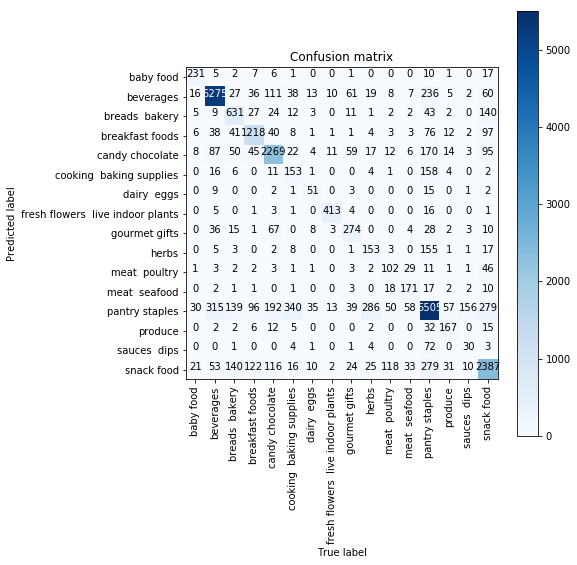

In [39]:
plot_confusion_matrix(y_valid, valid_pred, 
                      category2_classes, figsize=(8, 8))

### 6.2)-Visualizing coefficients

In [40]:
def visualize_coefficients(classifier_coefs, feature_names, 
                           n_top_features=25, title='Coefs', 
                           save_path=None):
    # get coefficients with large absolute values 
    coef = classifier_coefs.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, 
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" 
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), 
            coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), 
               feature_names[interesting_coefficients], 
               rotation=90, ha="right")
    plt.title(title);
    if save_path:
        plt.savefig(save_path, dpi=300);

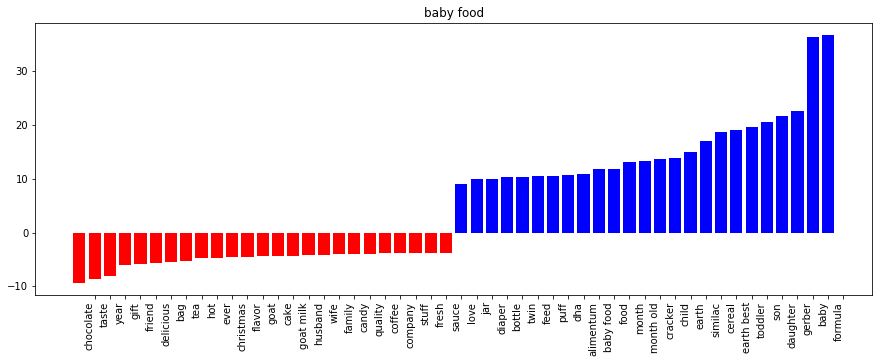

In [41]:
visualize_coefficients(tfidf_logit_pipeline.named_steps['logit'].coef_[0, :], 
                       tfidf_logit_pipeline.named_steps['tf_idf'].get_feature_names(),
                      title=category2_classes[0])

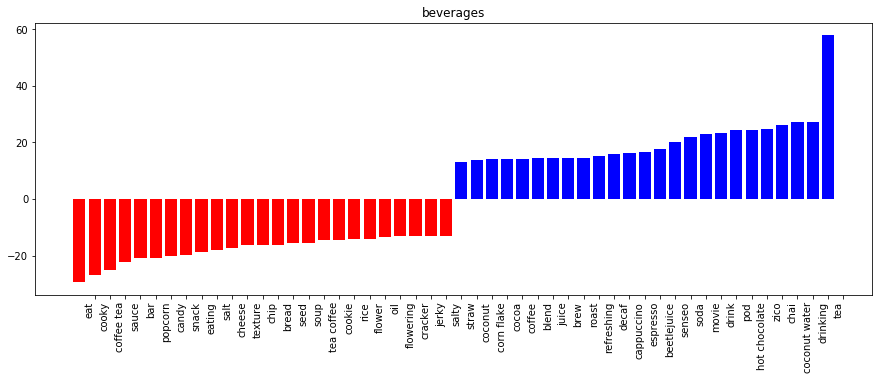

In [42]:
visualize_coefficients(tfidf_logit_pipeline.named_steps['logit'].coef_[1, :], 
                       tfidf_logit_pipeline.named_steps['tf_idf'].get_feature_names(),
                      title=category2_classes[1])

### 6.3)- Checking results with ELI5

ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions. It supports Sklearn, Xgboost, LightGBM and others

In [44]:
! pip3 install eli5

  Stored in directory: C:\Users\Hassan\AppData\Local\pip\Cache\wheels\2b\67\89\414471314a2d15de625d184d8be6d38a03ae1e983dbda91e84
Successfully built tabulate


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [45]:
import eli5

eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

In [46]:
train_texts[0], y_train[0]

('hungary given recipe hungarian goulash need sweet paprika terrific dish others purchase need',
 'herbs')

In [47]:
eli5.show_prediction(estimator=tfidf_logit_pipeline.named_steps['logit'],
                     vec=tfidf_logit_pipeline.named_steps['tf_idf'],
                     doc=train_texts[0])

# 7)-Hierarchical text classification
Now we are going to predict categories 2 and 3 at the same time. It's not straightfoward how you make your category 3 predictions consistent with category 2 predictions. Example: if the model predicts "breakfast foods" as category 2, then it's obliged to predicts subcategories of "breakfast foods" as category 3, for instance, "cereals". But not "spices seasonings". Formally, it's called hierarchical text classification.

In [48]:
# combine categories 2 and 3
df['Cat2_Cat3'] = df['Cat2'] + '/' + df['Cat3']

In [49]:
y_cat2_and_cat3 = df['Cat2_Cat3']

In [50]:
y_cat2_and_cat3.head()

0    herbs/spices  seasonings
1     breakfast foods/cereals
2     breakfast foods/cereals
3     breakfast foods/cereals
4     breakfast foods/cereals
Name: Cat2_Cat3, dtype: object

In [51]:
train_texts, valid_texts,y_train_cat2_and_cat3, y_valid_cat2_and_cat3 = \
    train_test_split(texts, y_cat2_and_cat3, 
                     random_state=17,
                     stratify=y_cat2_and_cat3, 
                     shuffle=True)

In [52]:
tfidf_logit_pipeline.fit(train_texts, y_train_cat2_and_cat3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  9.0min finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru... penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False))])

In [53]:
valid_pred_cat2_and_cat3 = tfidf_logit_pipeline.predict(valid_texts)

In [54]:
cat2_pred = pd.Series(valid_pred_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[0])
cat3_pred = pd.Series(valid_pred_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[1])

In [55]:
y_valid_cat2 = pd.Series(y_valid_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[0])
y_valid_cat3 = pd.Series(y_valid_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[1])

In [56]:
accuracy_score(y_valid_cat3, cat3_pred)

0.6370619299087854

In [57]:
accuracy_score(y_valid_cat2, cat2_pred)

0.758801408225316